Learnings

- Explore sklearn preprocessing tools
- Data processing takes forever


In [143]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [144]:
train_file = '/home/rushi/dev/data/housing/train.csv'
test_file = '/home/rushi/dev/data/housing/test.csv'
hd = pd.read_csv(train_file)

In [145]:
# parse the data dictionary

class Desc(object):
    def __init__(self, name, desc, desc_dict=None):
        self.desc_dict = desc_dict
        self.desc = desc
        self.name = name
        
    def add(self, val, val_desc):
        if self.desc_dict is None:
            self.desc_dict = {}
        self.desc_dict[val] = str(val) + '_' + val_desc
        
    def __repr__(self):
        ret = f'{self.name}: {self.desc} Quant: {self.desc_dict is None} '
        if self.desc_dict is not None:            
            ret +='\n'
            ret +='\n'.join([f'{k}: {v}' for k,v in self.desc_dict.items()])
        return ret
        
data_txt_file = '/home/rushi/dev/data/housing/data_description.txt'

data_dict = {}
data_dict['Id'] = Desc('Id', 'Index')
with open(data_txt_file, 'r') as f:
    curr_col = None
    for line in f.readlines():
        
        if line.strip() == '':
            # empty lines
            continue
            
        elif ':' in line.split(' ')[0]:
            # we are in a new column/description
            col_name, col_desc = line.split(':')
            curr_col = col_name
            data_dict[curr_col] = Desc(col_name, col_desc)
            
        else:
            # we are in column details
            line_splits = line.strip().split('\t')            
            val, val_desc = line_splits[0].strip(), ' '.join(line_splits[1:])            
            data_dict[curr_col].add(val, val_desc)

data_dict['SalePrice'] = Desc('SalePrice', 'Y')
cols = list(data_dict.keys())

assert len(data_dict) == len(hd.columns)
for v1, v2 in zip(data_dict.keys(), hd.columns):
    assert v1 == v2, (v1, v2)

In [146]:
import functools

def one_hot_encode(x, keys):
    x = str(x)
    res = np.zeros(len(keys))
    try:
        res[keys.index(x)] = 1
    except:
        # data has both of these descriptions.
        exceptions_map = {'C (all)' : 'C', 'Wd Shng': 'WdShing', 'WdShngl': 'WdShing',
                         'CmentBd' : 'CemntBd', 'Brk Cmn' : 'BrkComm', 'NA': 'None'}
        if x in exceptions_map.keys():
            x = exceptions_map[x]
    
        try:
            res[keys.index(x)] = 1
        except:
            # all zeros
            pass
    return res

converters_v1 = {}

for name, pred in data_dict.items():
    if pred.desc_dict is not None:  
       
        # create one hot encoding for qualitative inputs        
        keys = list(pred.desc_dict.keys())
        converters_v1[name] = functools.partial(one_hot_encode, keys=keys)
nhd = pd.read_csv(train_file, converters=converters_v1)

In [147]:
from itertools import repeat

# TODO: use basic target encoding
# TODO: Lookup bayesian target encoding

def ordinal_encode(x, keys):    
    return keys.index(x)

ordinal_keys = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
                'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
                'GarageQual', 'GarageCond', 'PoolQC'] + ['BsmtFinType1', 'BsmtFinType2', 'GarageFinish']

converters_v2 = {}

is_one_hot = []  # Bad name. should be is_not_one_hot
for name, pred in data_dict.items():
    
    if pred.desc_dict is not None:  
        
        # create one hot encoding for qualitative inputs        
        
        if name in ordinal_keys:            
            # reversed iterators since the values look [Good, Avg, Bad] and we want higher values for better quality
            # i.e we want +ve correlations with these predictors
            keys = list(reversed(list(pred.desc_dict.keys()) + ["NA"])) # NB: NA: Some test data does not have values
            converters_v2[name] = functools.partial(ordinal_encode, keys=keys)
            is_one_hot.append(1)
        else:
            keys = list(pred.desc_dict.keys())        
            converters_v2[name] = functools.partial(one_hot_encode, keys=keys)
            is_one_hot.extend([0] * len(keys))
    else:
        is_one_hot.append(1)

nhd_v2 = pd.read_csv(train_file, converters=converters_v2)
nhd_test = pd.read_csv(test_file, converters=converters_v2)

In [148]:
# Important: Convert to np arrays
def get_fdata(np_array):    
    rows = []
    for ii in np_array:
        row = np.array([], dtype=np.float64)
        for jj in ii:
            row = np.append(row, jj)
        rows.append(row)        
    return rows

fdata = np.concatenate([get_fdata(nhd.to_numpy())])
fdata_v2 = np.concatenate([get_fdata(nhd_v2.to_numpy())])
fdata_test = np.concatenate([get_fdata(nhd_test.to_numpy())])
fdata.shape, fdata_v2.shape, fdata_test.shape

((1460, 356), (1460, 274), (1459, 273))

In [149]:
# Get full axis values
full_axis = []
for key, value in data_dict.items():
    if value.desc_dict is not None:
        full_axis.extend([f'{key}_{x}'.replace(' ', '_') for x in value.desc_dict.values()])
    else:
        full_axis.append(value.name)
full_axis = np.array(full_axis)
print(full_axis[:5], full_axis.shape)

['Id' 'MSSubClass_20_1-STORY_1946_&_NEWER_ALL_STYLES'
 'MSSubClass_30_1-STORY_1945_&_OLDER'
 'MSSubClass_40_1-STORY_W/FINISHED_ATTIC_ALL_AGES'
 'MSSubClass_45_1-1/2_STORY_-_UNFINISHED_ALL_AGES'] (356,)


In [150]:
# Get full axis values v2
full_axis_v2 = []
for key, value in data_dict.items():
    if value.desc_dict is not None and key not in ordinal_keys:
        full_axis_v2.extend([f'{key}_{x}'.replace(' ', '_') for x in value.desc_dict.values()])
    else:
        full_axis_v2.append(value.name)
full_axis_v2 = np.array(full_axis_v2)
print(full_axis_v2[:5], full_axis_v2.shape)

['Id' 'MSSubClass_20_1-STORY_1946_&_NEWER_ALL_STYLES'
 'MSSubClass_30_1-STORY_1945_&_OLDER'
 'MSSubClass_40_1-STORY_W/FINISHED_ATTIC_ALL_AGES'
 'MSSubClass_45_1-1/2_STORY_-_UNFINISHED_ALL_AGES'] (274,)


In [234]:
def manual_clean(data, x_axis, is_train=True):
    # Replace index with intercept
    x = data[:,:-1].copy() if is_train else data.copy()# remove y
    x[:,0] = np.ones(x.shape[0]) # replace index with intercept
    data_dict['Id'] = Desc('Intercept', 'Intercept')
    data_dict['Id']
    x_axis = x_axis[:-1] # remove y 
    y = fdata[:,-1].copy() if is_train else None

    # MANUAL CLEANING
    lot_frontage_idx = x_axis.tolist().index('LotFrontage')
    mas_vnr_idx = x_axis.tolist().index('MasVnrArea')
    gbuilt_idx = x_axis.tolist().index('GarageYrBlt')
    ybuilt_idx = x_axis.tolist().index('YearBuilt')
    x[np.isnan(x[:, lot_frontage_idx]), lot_frontage_idx] = 0 # set lot frontage to 0 when unavailable
    x[np.isnan(x[:, mas_vnr_idx]), mas_vnr_idx] = 0 # set masonry veneer area to 0 when unavailable
    x[:, gbuilt_idx] = np.where(np.isnan(x[:, gbuilt_idx]), x[:, ybuilt_idx], x[:, gbuilt_idx]) # when garage built year unknown, use year property built
    
    return x, y, x_axis

x_v1, y_v1, axis_v1 = manual_clean(fdata, full_axis)
x_v2, y_v2, axis_v2 = manual_clean(fdata_v2, full_axis_v2)
x_test, y_test, axis_rtest = manual_clean(fdata_test, full_axis_v2, is_train=False)

In [235]:
# VIEW data
def dr(data, axis): # describe row
    return {x: v for x,v in zip(axis, data)}

In [236]:
def split_data(x, y):    
    test_idx = int(x.shape[0] * 0.8) + 1
    x_train = x[:test_idx, : ]
    y_train = y[:test_idx]
    x_test = x[test_idx:, :]
    y_test = y[test_idx:]
    
    return x_train, y_train, x_test, y_test

x1_train, y1_train, x1_test, y1_test = split_data(x_v1, y_v1)
x2_train, y2_train, x2_test, y2_test = split_data(x_v2, y_v2)

# Normalized data

# Data Version 3 is normalized values for quantitative X values
# Y is scaled down by 1e4
y3_scale = 1e4
y_v3 = y_v2.copy() / y3_scale

x_v3 = x_v2.copy()
axis_v3 = axis_v2.copy()

is_one_hot_np = np.array(is_one_hot[:-1]) # ignore intercept column for one_hot and y column
quant_indices = np.where(is_one_hot_np > 0)
quant_indices_x = quant_indices[0][1:]
assert (is_one_hot_np.shape[0] == x_v2.shape[1])

def normalize_all(x_o, x_train):
    x = x_o.copy()
    for idx in quant_indices_x:        
        x[:, idx] = (x[:, idx] - np.mean(x_train[:, idx]))/np.sqrt((np.var(x_train[:, idx])))
    return x

x3_train_o, y3_train, x3_test_o, y3_test = split_data(x_v3, y_v3)

x3_train = normalize_all(x3_train_o, x3_train_o)
x3_test = normalize_all(x3_test_o, x3_train_o)

# Normalize test data
x_rtest = normalize_all(x_test, x3_train_o)

# clean test data  # TODO: Check if OK
x_rtest[np.isnan(x_rtest)] = 0

# shape test
print(x3_train.shape, x_rtest.shape)

# Normalization Test
idx = axis_v3.tolist().index('GrLivArea')
print(np.sum(x3_train[:, idx]), np.sum(x3_test[:, idx]), np.sum(x_rtest[:, idx]))

(1169, 273) (1459, 273)
1.3145040611561853e-13 37.09446025822451 -47.67311227516237


In [237]:
from sklearn import linear_model

# Fit on a single variable
lot_frontage_idx = full_axis.tolist().index('LotFrontage')
LR = linear_model.LinearRegression(fit_intercept=False)
x1_train_int = x1_train[:, [0,lot_frontage_idx]]
res = LR.fit(x1_train_int, y1_train)
print(f"Coef: {res.coef_}")
print("Train score: {} Test score: {}".format(res.score(x1_train_int, y_train), res.score(x1_test[:, [0, lot_frontage_idx]], y1_test)))

# Fit on everything
LR = linear_model.LinearRegression(fit_intercept=False)
res_full_fit = LR.fit(x1_train, y1_train)
res_full_fit.score(x1_test, y1_test)
print("Train score: {} Test score: {}".format(res_full_fit.score(x1_train, y1_train), res_full_fit.score(x1_test, y1_test)))

Coef: [150462.09068574    523.28709799]
Train score: 0.051491390319412966 Test score: 0.013990042282039816
Train score: 0.9395495195087282 Test score: 0.6633091689051294


In [238]:
import scipy.stats
def get_corrs(x,y):

    # Find the most correlated variables
    def corr(x):
        return scipy.stats.pearsonr(x, y)
    corrs = np.apply_along_axis(corr, 0, x).T
    corrs[np.isnan(corrs)] = 0
    corrs = corrs[:,0] # ignore the p value
    return corrs

corrs = get_corrs(x1_train, y1_train)
corrs_v2 = get_corrs(x2_train, y2_train)
corrs_v3 = get_corrs(x3_train, y3_train)

# largest corrs
largest_corrs = np.argsort(-np.abs(corrs)) # -corrs since argsort sorts from min to max and we want largest corr
largest_corrs_v2 = np.argsort(-np.abs(corrs_v2))
largest_corrs_v3 = np.argsort(-np.abs(corrs_v3))

#dr(corrs[largest_corrs], axis_v1[largest_corrs])
#dr(corrs_v2[largest_corrs_v2], axis_v2[largest_corrs_v2])
#dr(corrs_v3[largest_corrs_v3], axis_v3[largest_corrs_v3])

/home/rushi/dev/git/python/environment/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [239]:
def fit(x_train, y_train, x_test, y_test):
    LR = linear_model.LinearRegression(fit_intercept=True)
    res = LR.fit(x_train, y_train)    
    return res.score(x_train, y_train), res.score(x_test, y_test), res

print("base top 20", fit(x1_train[:, largest_corrs[:20]], y1_train, x1_test[:, largest_corrs[:20]], y1_test))
print("v2 top 20", fit(x2_train[:, largest_corrs_v2[:20]], y2_train, x2_test[:, largest_corrs_v2[:20]], y2_test))
print("v2 top 140", fit(x2_train[:, largest_corrs_v2[:140]], y2_train, x2_test[:, largest_corrs_v2[:140]], y2_test))

print("v3 top 20", fit(x3_train[:, largest_corrs_v3[:20]], y3_train, x3_test[:, largest_corrs_v3[:20]], y3_test))
print("v3 top 140", fit(x3_train[:, largest_corrs_v3[:140]], y3_train, x3_test[:, largest_corrs_v3[:140]], y3_test))

print("v2 all", fit(x2_train, y2_train, x2_test, y2_test)) # TODO: needs explanation
print("v3 all", fit(x3_train, y3_train, x3_test, y3_test)) # TODO: needs explanation

# Look at the coeffecients since it gives information about actual influece in a combined setting.
# Especially since all of the inputs are now normalized.
#num_preds = None
#_,_,res = fit(x3_train[:, largest_corrs_v3[:num_preds]], y3_train, x3_test[:, largest_corrs_v3[:num_preds]], y3_test)
#dr(res.coef_, axis_v3[largest_corrs_v3[:num_preds]]), res.intercept_
# The coeffecients explode after the first  20 or so predictors.
# This is likely because they are heavily offset by the other predictors in the one-hot group.

base top 20 (0.8357951195579905, 0.633514671565675, LinearRegression())
v2 top 20 (0.8262935096544097, 0.6575572381355508, LinearRegression())
v2 top 140 (0.9083324699290795, 0.7096104843892723, LinearRegression())
v3 top 20 (0.8262935096544098, 0.6575572381355501, LinearRegression())
v3 top 140 (0.9077744307987841, 0.7108541562776536, LinearRegression())
v2 all (0.9253331622758502, -5236938.480691137, LinearRegression())
v3 all (0.9253371712961918, -7.447342444841612e+17, LinearRegression())


In [767]:
import os
from datetime import datetime 

def write_data(y, prefix):
    upload_dir = '/home/rushi/dev/data/housing/upload'
    #os.makedirs(upload_dir)
    timestamp = datetime.now().strftime('%Y%m%d.%H%M%S')    
    file_name = os.path.join(upload_dir, f'{prefix}_{timestamp}')
    print("Writing to ", file_name)
    with open(file_name, 'w') as f:
        f.write('Id,SalePrice\n')
        debug_count = 0
        for idx, val in zip(fdata_test[:,0], y):
            out = f'{int(idx)},{val}\n'
            f.write(out)
            if debug_count < 1:
                print(out)
            debug_count += 1
        print(f"Wrote {debug_count} rows")
    return file_name

In [751]:
# TODO: Can we weight these observations somehow ?

def regress(x, y, reg_lambda=0):
    xT = x.T
    xTx = xT @ x
    xTy = xT @ y
    #xTx_inv = np.linalg.solve(xTx, np.eye(xTx.shape[0])) # singular
    xTx_inv  = np.linalg.solve(xTx + reg_lambda * np.eye(xTx.shape[0]), np.eye(xTx.shape[0])) # regularized
    B = xTx_inv @ xTy
    return B, xTx_inv

# yhat = xTy
def pred(B, x):
    return x @ B

def scale(y, scale):
    return np.maximum(0, y * scale)

# R^2 score
def r2(yhat, y):
    tss = np.sum((y - np.mean(y)) ** 2)
    rss = np.sum((yhat - y) ** 2)
    return 1 - (rss/tss)

# sigma_squared_hat (noise variance estimate - mean 0)
def est_noise_var(y, yhat, num_samples, num_preds):
    return 1/(num_samples - num_preds - 1) * np.sum((y - yhat) ** 2)

def z_scores(B, B_var):
    return B/np.sqrt(np.diag(B_var))

def metrics(y, yhat, scale=1):
    y = y * scale
    yhat = yhat * scale
    mse = np.sum((y - yhat)**2)/y.shape[0]
    base_rate = np.sum((y - np.mean(y))**2)/y.shape[0]
    mean_abs_error = np.sum(np.abs(y - yhat))/y.shape[0]
    return {'mse' : mse,
            'base_rate' : base_rate,
            'reduction' : 100 * (base_rate - mse)/base_rate,
            'mae' : mean_abs_error,
            'r2': r2(yhat, y),
           }

In [739]:
# Train using manual process and all preds

from IPython.display import display
B, xTx_inv = regress(x3_train, y3_train, 0.0001)

yhat_test = pred(B, x3_test)
yhat_train = pred(B, x3_train)
noise_var = est_noise_var(y3_train, yhat_train, x3_train.shape[0], x3_train.shape[1])
B_var = xTx_inv * noise_var
z_s = z_scores(B, B_var)
print("R2 score: Test: {} Train: {}".format(r2(yhat_test, y3_test), r2(yhat_train, y3_train)))
print("Noise Var: ", noise_var)
print("Train Metrics: {}\nTest Metrics: {}".format(metrics(y3_train, yhat_train), metrics(y3_test, yhat_test)))

# write the all preds solution to disk
y_rtest = np.maximum(0, pred(B, x_rtest) * y3_scale)
file_path = write_data(y_rtest, prefix='normalized_all_preds')
#!cat $file_path

R2 score: Test: 0.6649914615714716 Train: 0.9253331618764244
Noise Var:  6.050317963635546
Train Metrics: {'mse': 4.632193821602921, 'base_rate': 62.03816765264016, 'reduction': 92.53331618764246, 'mae': 1.441586189272393, 'r2': 0.9253331618764244}
Test Metrics: {'mse': 22.508604709919936, 'base_rate': 67.18815232442792, 'reduction': 66.49914615714715, 'mae': 2.217755850577529, 'r2': 0.6649914615714716}
Writing to  /home/rushi/dev/data/housing/upload/normalized_all_preds_20211223.093418
1461,124417.677526597



In [735]:
# Check the effects of regularization
def regularized_regress(x_train, y_train, x_eval, y_eval):
    
    reg_factors = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 10, 20, 50, 1000, 2000, 5000, 10000]
    
    eval_res = {}
    train_res = {}
    
    coefs = []
    for reg_factor in reg_factors:
        B, xTx_inv = regress(x_train, y_train, reg_factor)
        yhat_train = pred(B, x_train)
        met_train = metrics(y_train, yhat_train)
        
        yhat_eval = pred(B, x_eval)
        met_eval = metrics(y_eval, yhat_eval)
                
        # Also evaluate and store z scores
        num_preds = x_train.shape[1]
        num_samples = x_train.shape[0]
        noise_var = est_noise_var(y_train, yhat_train, num_samples, num_preds)
        B_var = xTx_inv * noise_var        
        z_s = z_scores(B, B_var)
        
        train_res[reg_factor] = {'metrics' : met_train,
                                 'coefs': B,
                                 'z_score': z_s}
        
        eval_res[reg_factor] = {'metrics' : met_eval,
                                'coefs': B,
                                'z_score': z_s}
        
    return train_res, eval_res

def plot_regularized_results(res, plt, metric='mae', *args):
    plt.set_xscale('log')
    reg_factors = list(res.keys())
    plt.plot(reg_factors, [y['metrics'][metric] for y in res.values()], *args)
    plt.set_xticks(reg_factors)

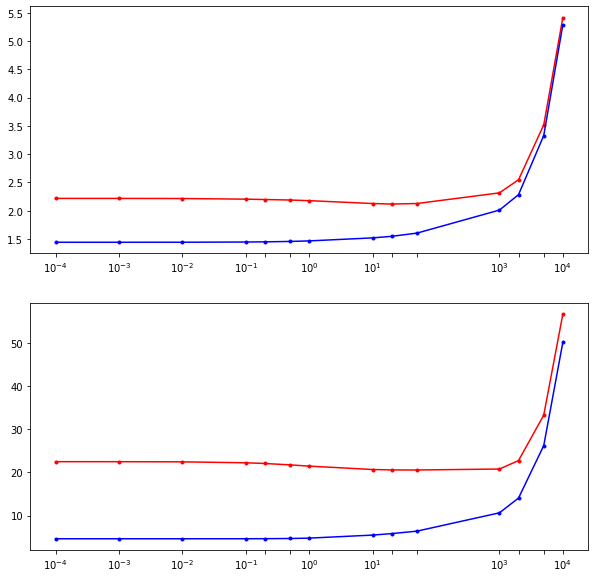

In [725]:
#y_rtest = pred(B, x_rtest)    
#write_data(scale(y_rtest, y3_scale), prefix="allpred_reg{}".format(reg_factor))    

train_res, eval_res = regularized_regress(x3_train, y3_train, x3_test, y3_test)

fig, ax = plt.subplots(2,1)
plot_regularized_results(eval_res, ax[0], 'mae', 'r.-')
plot_regularized_results(train_res, ax[0], 'mae', 'b.-')
plot_regularized_results(eval_res, ax[1], 'mse', 'r.-')
plot_regularized_results(train_res, ax[1], 'mse', 'b.-')
# Best results see, to be at regularization of 20 (~17.5K)

In [243]:
# Predictors with Z scores with p<0.05
import scipy.stats
T_dist = scipy.stats.t(df = x_train.shape[0])
z_good_indices = np.where(np.abs(z_s) > T_dist.isf(0.05))[0]
print("Num good indices: ", len(z_good_indices))
dr(zip(B[z_good_indices], z_s[z_good_indices]), axis_v3[z_good_indices])

Num good indices:  31


{'LotFrontage': (0.0854609723284161, 2.148402218909648),
 'LotArea': (0.5966215018988059, 11.467397018608555),
 'OverallQual': (1.0291921503603167, 14.660848885199876),
 'OverallCond': (0.621935465442716, 12.760760642547845),
 'YearBuilt': (0.8671272823932696, 6.856054365541266),
 'YearRemodAdd': (0.11793626665957468, 2.0418626299311895),
 'MasVnrArea': (0.5043445892040956, 9.831499377483492),
 'ExterQual': (0.18628989757184666, 3.122579660223037),
 'ExterCond': (-0.08642373564942174, -2.263144080456449),
 'BsmtQual': (0.4790828501119957, 5.79142840442597),
 'BsmtCond': (-0.5650652907851539, -8.015243571307392),
 'BsmtExposure': (0.4517324832789309, 9.780244197350882),
 'HeatingQC': (0.12885340467230577, 2.812858805248398),
 'FullBath': (0.23765444277182046, 3.946518323444216),
 'HalfBath': (0.15407660254809796, 2.8998183496441263),
 'BedroomAbvGr': (-0.5698140440620962, -9.993688869773928),
 'KitchenAbvGr': (-0.3629129186081458, -5.574203166231138),
 'KitchenQual': (0.4487776405862762

In [244]:
# Implement forward selection (Naieve)

def forward_select(x, y, x_test, y_test, axis, reg=0.0001):
    model_indices = []
    candidate_indices = list(range(x.shape[1]))
    
    final_coefs = None  
    final_loss = None
    loss_list = []
    
    while len(candidate_indices) > 0:
        
        least_loss = None
        least_loss_idx = None
        for idx in candidate_indices:
            
            curr_pred_indices = model_indices + [idx]
            B, _  = regress(x[:, curr_pred_indices], y, reg)
            yhat_test = pred(B, x_test[:, curr_pred_indices])
            curr_metrics = metrics(y_test, yhat_test)
            
            loss = curr_metrics['mse']
            if not least_loss or loss < least_loss:
                least_loss_idx = idx
                least_loss = loss
                final_coefs = B            
        
        if not len(loss_list) or least_loss < loss_list[-1]:
            #print(f"Selected pred: {axis[least_loss_idx]} with least loss: {least_loss}")
            model_indices.append(least_loss_idx)
            candidate_indices.remove(least_loss_idx)
            loss_list.append(least_loss)            
        else:
            break
        
    return model_indices, final_coefs, loss_list

model_indices, final_coefs, loss_list = forward_select(x3_train, y3_train, x3_test, y3_test, axis_v3)

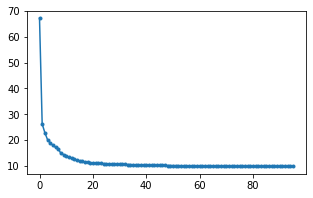

In [289]:
plt.rcParams['figure.figsize'] = [5,3]
plt.plot(loss_list, '.-')

In [247]:
# Select the top 40 preds (via manual inspection - TODO: Use the standard error and choose the smallest model within a single standard deviation of the error rate)
num_preds = 40
coefs = final_coefs[:num_preds]
best_indices = model_indices[:num_preds]

# Use them for forecasting the train and validation data:
yhat_train = pred(coefs, x3_train[:, best_indices])
yhat_test = pred(coefs, x3_test[:, best_indices])
print("Train metrics : {} ".format(metrics(y3_train, yhat_train, scale=y3_scale)))
print("Test metrics : {} ".format(metrics(y3_test, yhat_test, scale=y3_scale)))

# Forecast real test data
yhat_rtest = pred(coefs, x_rtest[:, best_indices])

# scale yhat
yhat_rtest = np.maximum(0, yhat_rtest * y3_scale)

print("NaNs in output: ", np.where(np.isnan(yhat_rtest)))

# write to disk
file_name = write_data(yhat_rtest, prefix='forward_sel')

Train metrics : {'mse': 1198711858.572373, 'base_rate': 6203816765.264016, 'reduction': 80.67783263225765, 'mae': 23698.946302621374} 
Test metrics : {'mse': 1033326866.6482626, 'base_rate': 6718815232.442791, 'reduction': 84.62040060785283, 'mae': 21037.868385176153} 
NaNs in output:  (array([], dtype=int64),)
Writing to  /home/rushi/dev/data/housing/upload/forward_sel_20211222.114148


(array([11., 39., 83., 64., 29., 25., 20.,  6.,  3.,  6.,  1.,  2.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 52500.,  87125., 121750., 156375., 191000., 225625., 260250.,
        294875., 329500., 364125., 398750., 433375., 468000., 502625.,
        537250., 571875., 606500., 641125., 675750., 710375., 745000.]),
 <a list of 1 Patch objects>)

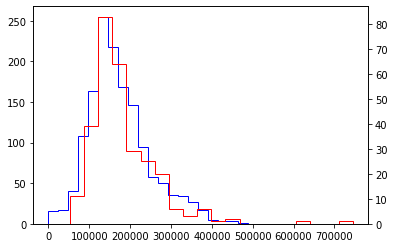

In [198]:
plt.hist(yhat_rtest, bins=20, histtype='step', color='blue')
plt2 = plt.twinx()
plt.hist(y3_test * y3_scale, bins=20, histtype='step', color='red')

In [501]:
def graph_preds(x, y, coefs=None, axis=None):    
    import math
    num_columns = 5
    num_rows = math.ceil(x.shape[1] / num_columns)    
    fig, ax = plt.subplots(num_rows, num_columns)
    #if ax.ndim == 1:
    #    ax = ax[np.newaxis, :]
    #    plt.rcParams['figure.figsize'] = [10,10]
    #else:
    #    plt.rcParams['figure.figsize'] = [num_rows * 4, num_columns * 3]
    plt.rcParams['figure.figsize'] = [5,5]
    for idx in range(x.shape[1]):
        #print(idx // num_columns, idx%num_columns, ax.shape)
        sub_plot = ax[idx // num_columns, idx % num_columns]        
        sub_plot.plot(x[:, idx], y, '.')
        if coefs is not None:
            reg_plot = sub_plot.twinx()
            reg_plot.plot(x[:, idx], coefs[idx] * x[:,idx], 'r.-')
        if axis is not None:
            sub_plot.set_xlabel(str(axis[idx]))

In [502]:
def get_ordinal_indices(x, threshold=20):
    ordinal_indices = []
    for idx in range(x.shape[1]):
        if np.unique(x[:, idx]).shape[0] < threshold:
            ordinal_indices.append(idx)    
    return ordinal_indices

def get_quant_indices(x):
    ord_indices = get_ordinal_indices(x)    
    quant_indices=list(set(list(range(x.shape[1]))) - set(ord_indices))
    return quant_indices

['MiscVal' '3SsnPorch']


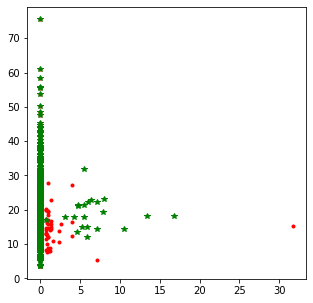

In [503]:
x_v3.shape, x3_train.shape
#len(get_quant_indices(x_v3)), len(get_quant_indices(x3_train))
added_quants = list(set(get_quant_indices(x_v3)) - set(get_quant_indices(x3_train)))
print(axis_v3[added_quants])
#graph_preds(x3_train[:, added_quants], y3_train, axis=axis_v3)
plt.rcParams['figure.figsize'] = [5,5]
plt.plot(x3_train[:, added_quants[0]], y3_train, 'r.')
plt.plot(x3_train[:, added_quants[1]], y3_train, 'g*')

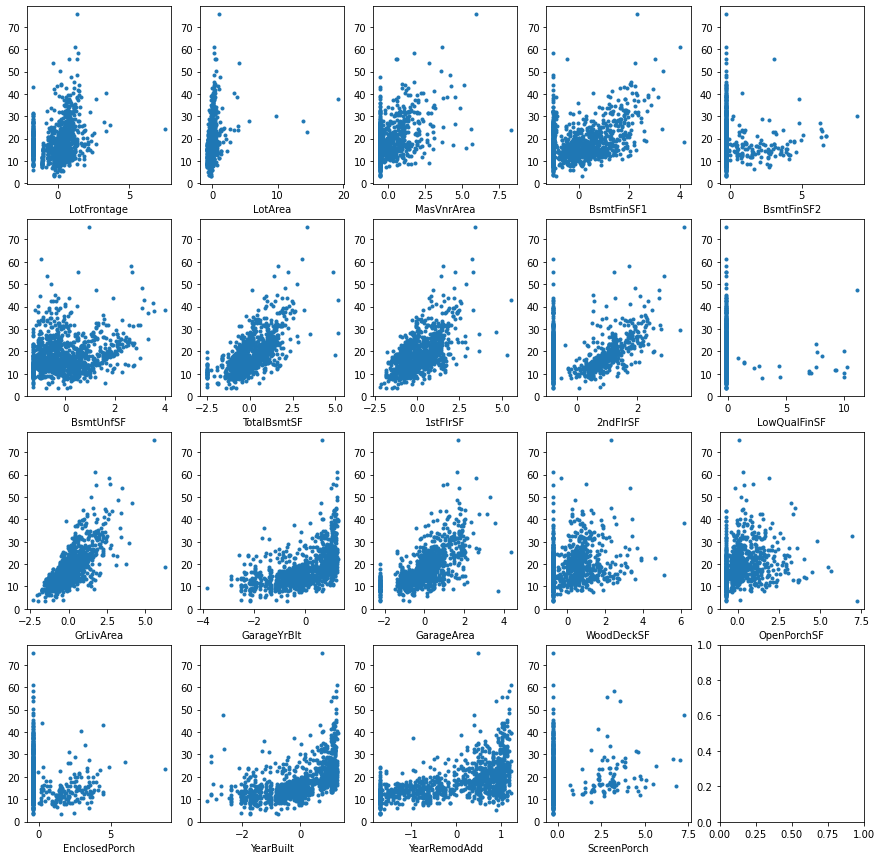

In [508]:
# Graph the quantitative preds
plt.rcParams['figure.figsize'] = [15,15]
quant_indices=get_quant_indices(x3_train)
graph_preds(x3_train[:, quant_indices], y3_train, axis=axis_v3[quant_indices])

In [849]:
def basis_expand(x, quant_indices, axis):
    x = x.copy()
    
    add_to_axis = []
    new_preds = []
    quant_cond_indices = []
    for idx in quant_indices:
        # Lots of values at 0. Split into two predictors based on conditional.        
        if scipy.stats.mode(x[:, idx])[0] == 0:
            new_preds.append(np.where(x[:, idx] == 0, 1, 0)[:,np.newaxis])
            add_to_axis.append(axis[idx] + "_atzero")
            quant_cond_indices.append((idx, x.shape[1] + len(new_preds) - 1))
            #print("Used: ", idx, scipy.stats.mode(x[:, idx])[0])
        else:
            #print("Did not use: ", idx, scipy.stats.mode(x[:, idx])[0])
            pass
    x = np.concatenate([x] + new_preds, axis=1)
    axis = np.concatenate([axis] + [np.array(add_to_axis)], axis=0)
    return x, axis, quant_cond_indices

def normalize_all(x_o, x_train, quant_indices, set_to_zero=False):
    x = x_o.copy()
    for idx in quant_indices:        
        if set_to_zero:
            x[:, idx] = np.where(x[:, idx] != 0, (x[:, idx] - np.mean(x_train[:, idx]))/np.sqrt(np.var(x_train[:, idx])), 0)
        else:
            x[:, idx] = (x[:, idx] - np.mean(x_train[:, idx]))/np.sqrt((np.var(x_train[:, idx])))
    return x

In [841]:
# Basis expand training data
x_v4, axis_v4, quant_cond_indices_train_v4 = basis_expand(x_v3.copy(), get_quant_indices(x_v3), axis_v3)
y_v4 = y_v3.copy() # already scaled

x4_train_o, y4_train, x4_eval_o, y4_eval = split_data(x_v4, y_v4)

# normalize the quant values (has > 20 unique values)
quant_indices=get_quant_indices(x4_train_o)
x4_train = normalize_all(x4_train_o, x4_train_o, quant_indices)
x4_eval = normalize_all(x4_eval_o, x4_train_o, quant_indices)

In [847]:
# also process test data
x4_test, _, quant_cond_indices_test = basis_expand(x_test, get_quant_indices(x_v3), axis_v3)
x4_test = normalize_all(x4_test, x4_train_o, quant_indices)

# clean test data  # TODO: Check if OK
x4_test[np.isnan(x4_test)] = 0

print(x4_train.shape, x4_eval.shape, x4_test.shape, x4_test.shape, x_v3.shape)

(1169, 288) (291, 288) (1459, 288) (1459, 288) (1460, 273)


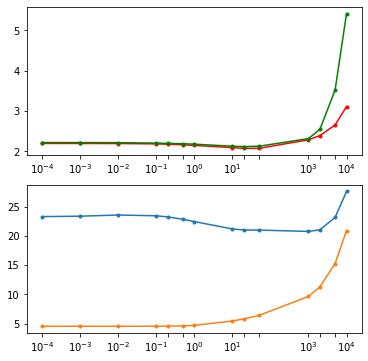

In [878]:
train_res_v4, eval_res_v4 = regularized_regress(x4_train, y4_train, x4_eval, y4_eval)
train_res_v3, eval_res_v3 = regularized_regress(x3_train, y3_train, x3_test, y3_test) # In v3, eval was called test incorrectly

plt.rcParams['figure.figsize'] = [6,6]
fix, ax = plt.subplots(2,1)
plot_regularized_results(eval_res_v4, ax[0], 'mae', 'r.-')
plot_regularized_results(eval_res_v3, ax[0], 'mae', 'g.-')

plot_regularized_results(eval_res_v4, ax[1], 'mse', '.-')
plot_regularized_results(train_res_v4, ax[1], 'mse', '.-')

Writing to  /home/rushi/dev/data/housing/upload/reg_cond_regress_20211223.110412
1461,118464.85682678745

Wrote 1459 rows


(array([ 50., 147.,  54.,  26.,   9.,   3.,   0.,   0.,   1.,   1.]),
 array([ 52500., 121750., 191000., 260250., 329500., 398750., 468000.,
        537250., 606500., 675750., 745000.]),
 <a list of 1 Patch objects>)

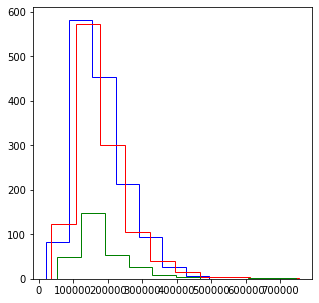

In [877]:
# Evaluate coeffecients of the V4 runs
# Let's use the "best" run at reg_factor 50
res = eval_res_v4[50]
coefs = np.array(res['coefs'])

y4_test = scale(pred(coefs, x4_test), y3_scale)
write_data(y4_test, prefix='reg_cond_regress') # Improvement over previous run by about

# Verify
plt.rcParams['figure.figsize'] = [5,5]
plt.hist(y4_test, histtype='step', color='blue')
plt.hist(y4_train * y3_scale, histtype='step', color='red')
plt.hist(y4_eval * y3_scale, histtype='step', color='green')

In [854]:
# Dig into the eval_res[50] results

res = eval_res_v4[50]
cond_indices = reduce(lambda state, x: state + [x[0], x[1]], quant_cond_indices_train_v4, [])
dr(zip(res['z_score'][cond_indices], res['coefs'][cond_indices]), axis_v4[cond_indices])

# Issue is that we did the basis expand prior to normalization.
# Next ,we do it the other way around.

{'LotFrontage': (1.6756196215026549, 0.23106278798773872),
 'LotFrontage_atzero': (0.43859421345656935, 0.13219864151292882),
 'MasVnrArea': (4.458696325657848, 0.5660330833909613),
 'MasVnrArea_atzero': (0.8891228067439589, 0.2922951797537685),
 'BsmtFinSF1': (2.6210648660682745, 0.6801284326736834),
 'BsmtFinSF1_atzero': (0.569689834504691, 0.176779016874125),
 'BsmtFinSF2': (1.008732017272233, 0.16229780267909),
 'BsmtFinSF2_atzero': (0.37571601432094637, 0.12737372618631326),
 'BsmtUnfSF': (-0.298515546378718, -0.07695861564587858),
 'BsmtUnfSF_atzero': (0.44981551233993256, 0.1342709250017009),
 'TotalBsmtSF': (2.588907335822498, 0.6884611320734848),
 'TotalBsmtSF_atzero': (0.9398311333461302, 0.3744121071043196),
 '2ndFlrSF': (2.7761703656875882, 0.7828950640632115),
 '2ndFlrSF_atzero': (0.3740982824087256, 0.12929504064396724),
 'LowQualFinSF': (0.42476618292197277, 0.04648969801708347),
 'LowQualFinSF_atzero': (0.2936992542318551, 0.11579932192296383),
 'GarageArea': (2.9320302

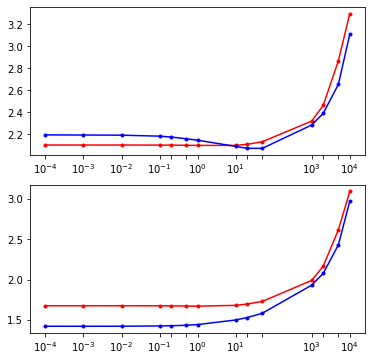

In [876]:
# Trim down to good Z score values
res = eval_res_v4[50]
z_s = np.array(res['z_score'])
coefs = np.array(res['coefs'])
T_dist = scipy.stats.t(df = x4_train.shape[0])
z_good = np.where(np.abs(z_s) > T_dist.isf(0.05))[0]

# Trimming down to coeffecients with good z values gives worse performance
train_res_z, eval_res_z = regularized_regress(x4_train[:,z_good], y4_train, x4_eval[:, z_good], y4_eval)
plt.rcParams['figure.figsize'] = [6,6]
fix, ax = plt.subplots(2,1)
plot_regularized_results(eval_res_z, ax[0], 'mae', 'r.-')
plot_regularized_results(eval_res, ax[0], 'mae', 'b.-')
plot_regularized_results(train_res_z, ax[1], 'mae', 'r.-')
plot_regularized_results(train_res, ax[1], 'mae', 'b.-')

In [856]:

# Do the same as v4 but additionally, also set values at 0 to 0 during normalization
x_v5, axis_v5, quant_cond_indices_train_v5 = basis_expand(x_v3.copy(), get_quant_indices(x_v3), axis_v3)
y_v5 = y_v3.copy() # already scaled

x5_train_o, y5_train, x5_eval_o, y5_eval = split_data(x_v5, y_v5)

# normalize the quant values (has > 20 unique values)
quant_indices=get_quant_indices(x5_train_o)
x5_train = normalize_all(x5_train_o, x5_train_o, quant_indices, set_to_zero=True) # setting the normalized values to 0
x5_eval = normalize_all(x5_eval_o, x5_train_o, quant_indices, set_to_zero=True)

# also process test data
x5_test, _, quant_cond_indices_test = basis_expand(x_test, get_quant_indices(x_v3), axis_v3)
x5_test = normalize_all(x5_test, x5_train_o, quant_indices)

# clean test data  # TODO: Check if OK
x5_test[np.isnan(x5_test)] = 0

print(x5_train.shape, x5_eval.shape, x5_test.shape)

(1169, 288) (291, 288) (1459, 288)


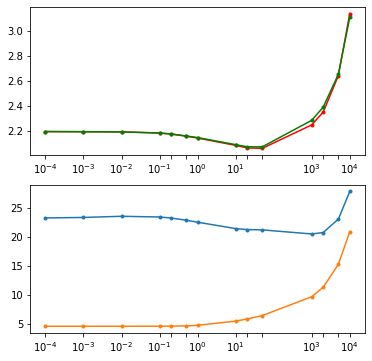

In [875]:
train_res_v5, eval_res_v5 = regularized_regress(x5_train, y5_train, x5_eval, y5_eval)

plt.rcParams['figure.figsize'] = [6,6]
fix, ax = plt.subplots(2,1)
plot_regularized_results(eval_res_v5, ax[0], 'mae', 'r.-')
plot_regularized_results(eval_res_v4, ax[0], 'mae', 'g.-')

plot_regularized_results(eval_res_v5, ax[1], 'mse', '.-')
plot_regularized_results(train_res_v4, ax[1], 'mse', '.-')

In [864]:
# Dig into the eval_res[50] results

res = eval_res_v5[50]
cond_indices = reduce(lambda state, x: state + [x[0], x[1]], quant_cond_indices_train_v5, [])
dr(zip(res['z_score'][cond_indices], res['coefs'][cond_indices]), axis_v4[cond_indices])

{'LotFrontage': (1.5813811542898684, 0.26699051505585203),
 'LotFrontage_atzero': (-0.5686506347764215, -0.1271328237782683),
 'MasVnrArea': (4.425108300482549, 0.570295839439094),
 'MasVnrArea_atzero': (0.49693083746035294, 0.16084220407963912),
 'BsmtFinSF1': (2.7192226808697897, 0.6111323235163226),
 'BsmtFinSF1_atzero': (-0.25277544844229854, -0.07970992790023246),
 'BsmtFinSF2': (0.8608270388154413, 0.1354347177300932),
 'BsmtFinSF2_atzero': (0.5049646772717351, 0.168779367124948),
 'BsmtUnfSF': (-0.7372091815993178, -0.1579168545161167),
 'BsmtUnfSF_atzero': (0.586063217273618, 0.18002255656406874),
 'TotalBsmtSF': (3.8832308946993046, 0.9369472407726391),
 'TotalBsmtSF_atzero': (0.5958049808221069, 0.23598664231843713),
 '2ndFlrSF': (2.8973031891738046, 0.8540613483033646),
 '2ndFlrSF_atzero': (-0.31867781214924146, -0.10732730071205765),
 'LowQualFinSF': (0.2055283810975034, 0.022484187702122682),
 'LowQualFinSF_atzero': (0.27853535408491914, 0.10916456899726157),
 'GarageArea'

Writing to  /home/rushi/dev/data/housing/upload/reg_cond_regress_0norm_20211223.110338
1461,107647.18194450966

Wrote 1459 rows


(array([ 22.,  60., 235., 347., 251., 202., 131.,  82.,  59.,  36.,  18.,
          9.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 20607.40344757,  54384.04436604,  88160.6852845 , 121937.32620297,
        155713.96712143, 189490.6080399 , 223267.24895836, 257043.88987683,
        290820.53079529, 324597.17171376, 358373.81263222, 392150.45355069,
        425927.09446915, 459703.73538762, 493480.37630608, 527257.01722455,
        561033.65814301, 594810.29906148, 628586.93997994, 662363.58089841,
        696140.22181687]),
 <a list of 1 Patch objects>)

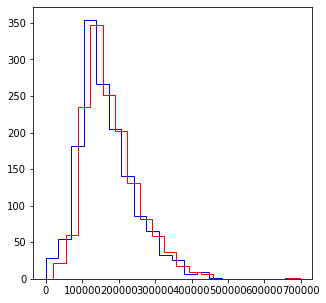

In [874]:
# Evaluate coeffecients of the V5 runs
# Let's use the "best" run at reg_factor 50
res = eval_res_v5[50]
coefs = np.array(res['coefs'])

y5_test = scale(pred(coefs, x5_test), y3_scale)
write_data(y5_test, prefix='reg_cond_regress_0norm') # Improvement over previous run by about

# Verify
plt.rcParams['figure.figsize'] = [5,5]
plt.hist(y5_test, histtype='step', color='blue', bins=20)
plt.hist(y4_test, histtype='step', color='red', bins=20)


# Much worse performance at test (~21K)